# Sensitivity analysis on effect differences from FFT window size

This file generates and displays data for the within-study parameter sensitivity analysis.

In [1]:
# imports
import os
from functools import partial
from math import log
from pathlib import Path

import pandas as pd

import tools.plots as plts
from tools.index_sensitivity import IndexSensitivity
from tools.r_link import Rlink
from study_settings.big_vicky import BigVickySettings, BigVickyToolbox
from study_settings.carara import CararaSettings, CararaToolbox

In [2]:
# settings and r_link
r_link = Rlink()
r_link.capture_rpy2_output(errorwarn_callback=print)
r_link.load_src("tools/r_funcs.R")
indices_of_interest = ["ACI", "ADI", "AEI", "BIO"]
output_path = Path("./output")
fft_window_sizes = [2**x for x in range(8, 16)] + [22050, 48000]
plts.plt.rcParams.update({"font.size": 16})

In [3]:
def experiment(df:pd.DataFrame, group_to_process:tuple, toolbox:IndexSensitivity, r_link:Rlink, marine:bool, factors:list, cross_effect:str):
    '''
    Models and obtains conditional effects for every set of values in the dataframe. Sets are defined by grouping the "Index", "Filtered", and "Band" columns.
    This function is designed for use in this notebook and may not generalise well.

    df: dataframe of index values
    group_to_process: tuple with the multi-index of the group to model
    toolbox: an instance of the IndexSensitivity class, with settings relevant to the data and models
    r_link: an instance of the Rlink class
    marine: whether the data is from Big Vicky's (True) or Carara (False)
    factors: which columns to treat as factors
    cross_effect: which column is treated as the cross effect (along with Window) 

    returns: a matplotlib figure of the model, and a table with the posterior effects summary
    '''
    samp_to_s = partial(toolbox.samples_to_s, toolbox.settings.sample_rate)
    s_to_samp = partial(toolbox.s_to_samples, toolbox.settings.sample_rate)
    conditional_effects = {}
    grouped_data = df.groupby(['Index', 'Filtered', 'Band'], observed=False) 
    group = grouped_data.get_group(group_to_process).copy()
    index, filtered, band = group_to_process
    log_window = index != "AEI"
    if log_window:
        group["Window"] = group["Window"].apply(lambda x: log(x))

    if index not in conditional_effects:
        conditional_effects[index] = {True: {}, False: {}}

    txt = '_filtered' if filtered else ''
    flt = txt.replace('_', ' ')
    all_text = (index, flt, band, cross_effect)
    model, effects = toolbox.build_model(r_link, marine, all_text, group, factors)
    filename = output_path / f"{cross_effect}_x_Window_conditional_effects_for_{index}_over{txt}_{band}_frequencies_Python"
    secax = ("Window duration (s)", (samp_to_s, s_to_samp))
    fig = plts.plot_conditional_effects(r_link,
                                    filename, 
                                    effects, 
                                    plot_points=True, 
                                    sec_ax=secax, 
                                    colors=toolbox.settings.colors, 
                                    unlog=log_window)
    conditional_effects[index][filtered][band] = effects
    posterior_ratios = r_link.r_src.get_posterior_ratios(model, num=toolbox.settings.num, den=toolbox.settings.den, cross=cross_effect)
    posterior_effects = r_link.r_src.get_posterior_ratio_difference(posterior_ratios)

    warnings = r_link.r_src.get_warnings()
    if warnings != r_link.null_value:
        print(warnings)

    return fig, posterior_effects

In [4]:
# from tools.populate_ipynb import CellAdder
# print(CellAdder.generate_index_definitions())

In [5]:
# index definitions
broadband_ACI_group = ('ACI', False, 'broadband')
broadband_ADI_group = ('ADI', False, 'broadband')
broadband_AEI_group = ('AEI', False, 'broadband')
broadband_BIO_group = ('BIO', False, 'broadband')
fish_extracted_ACI_group = ('ACI', False, 'fish')
fish_extracted_ADI_group = ('ADI', False, 'fish')
fish_extracted_AEI_group = ('AEI', False, 'fish')
fish_extracted_BIO_group = ('BIO', False, 'fish')
fish_filtered_ACI_group = ('ACI', True, 'fish')
fish_filtered_ADI_group = ('ADI', True, 'fish')
fish_filtered_AEI_group = ('AEI', True, 'fish')
fish_filtered_BIO_group = ('BIO', True, 'fish')
shrimp_extracted_ACI_group = ('ACI', False, 'shrimp')
shrimp_extracted_ADI_group = ('ADI', False, 'shrimp')
shrimp_extracted_AEI_group = ('AEI', False, 'shrimp')
shrimp_extracted_BIO_group = ('BIO', False, 'shrimp')
shrimp_filtered_ACI_group = ('ACI', True, 'shrimp')
shrimp_filtered_ADI_group = ('ADI', True, 'shrimp')
shrimp_filtered_AEI_group = ('AEI', True, 'shrimp')
shrimp_filtered_BIO_group = ('BIO', True, 'shrimp')

## Carara

In [6]:
# settings and frequency bands
carara_settings = CararaSettings
carara_settings.data_location = os.path.expanduser(carara_settings.data_location)
test_bands = [("broadband", (0, carara_settings.max_freq), False)]


In [7]:
carara_toolbox = CararaToolbox(carara_settings, fft_window_sizes, test_bands, indices_of_interest)

In [8]:
carara_index_values = carara_toolbox.get_index_values(output_file="output/terrestrial_index_values")

In [9]:
carara_df = carara_toolbox.create_dataframe(carara_index_values, output_path="output/terrestrial_dataframe.pkl")

### Carara - broadband ACI


In [10]:
carara_broadband_ACI_fig, carara_broadband_ACI_ratio_summary = experiment(carara_df,
          broadband_ACI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


broadband using ACI
Compiling Stan program...

Start sampling

starting worker pid=2738565 on localhost:11159 at 12:13:48.284
starting worker pid=2738581 on localhost:11159 at 12:13:48.354
starting worker pid=2738596 on localhost:11159 at 12:13:48.424
starting worker pid=2738611 on localhost:11159 at 12:13:48.494
starting worker pid=2738626 on localhost:11159 at 12:13:48.564

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00025 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.5 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000269 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 2.69 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [11]:
print(carara_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.12 0.00995



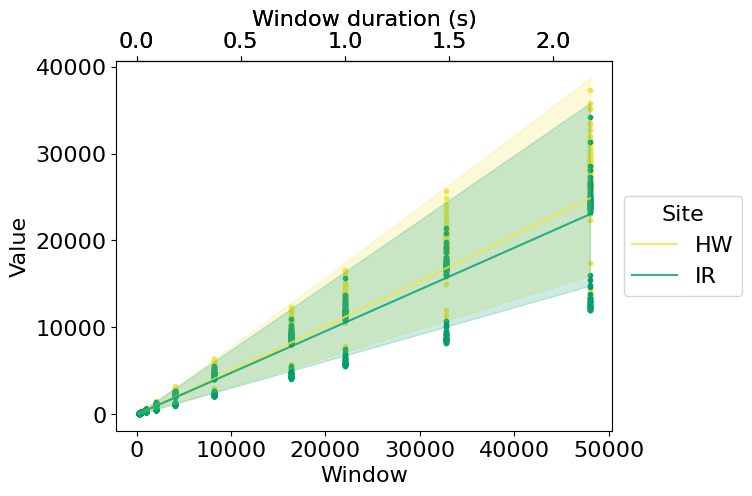

In [12]:
carara_broadband_ACI_fig


### Carara - broadband ADI


In [13]:
carara_broadband_ADI_fig, carara_broadband_ADI_ratio_summary = experiment(carara_df,
          broadband_ADI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


broadband using ADI
Compiling Stan program...

Start sampling

starting worker pid=2741243 on localhost:11159 at 12:33:53.709
starting worker pid=2741258 on localhost:11159 at 12:33:53.778
starting worker pid=2741273 on localhost:11159 at 12:33:53.847
starting worker pid=2741288 on localhost:11159 at 12:33:53.917
starting worker pid=2741303 on localhost:11159 at 12:33:53.986

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000245 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.45 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000256 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 2.56 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%] 

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [14]:
print(carara_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.06 0.0326



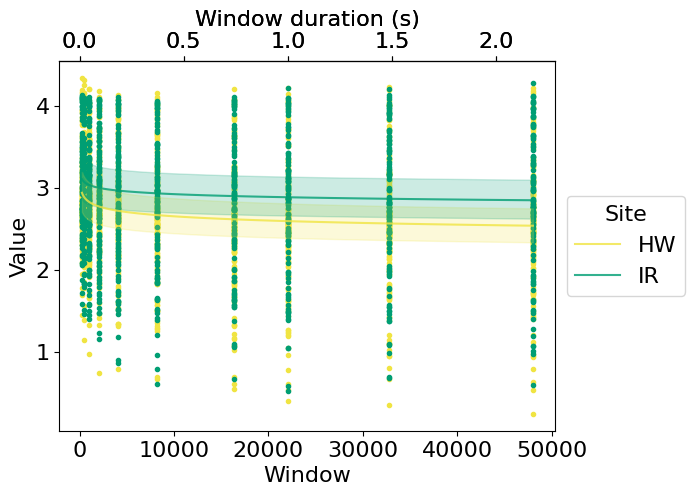

In [15]:
carara_broadband_ADI_fig


### Carara - broadband AEI


In [16]:
carara_broadband_AEI_fig, carara_broadband_AEI_ratio_summary = experiment(carara_df,
          broadband_AEI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


broadband using AEI
Compiling Stan program...

Start sampling

starting worker pid=2741911 on localhost:11159 at 12:36:16.323
starting worker pid=2741926 on localhost:11159 at 12:36:16.404
starting worker pid=2741941 on localhost:11159 at 12:36:16.474
starting worker pid=2741956 on localhost:11159 at 12:36:16.543
starting worker pid=2741971 on localhost:11159 at 12:36:16.613

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000363 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.63 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000362 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 3.62 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%] 

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [17]:
print(carara_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.01 0.0107



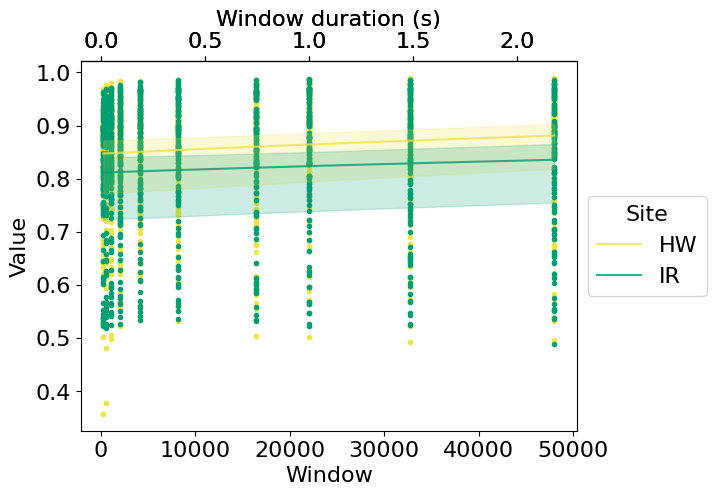

In [18]:
carara_broadband_AEI_fig


### Carara - broadband BIO


In [19]:
carara_broadband_BIO_fig, carara_broadband_BIO_ratio_summary = experiment(carara_df,
          broadband_BIO_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


broadband using BIO
Compiling Stan program...

Start sampling

starting worker pid=2746215 on localhost:11159 at 13:27:49.776
starting worker pid=2746230 on localhost:11159 at 13:27:49.844
starting worker pid=2746245 on localhost:11159 at 13:27:49.912
starting worker pid=2746260 on localhost:11159 at 13:27:49.982
starting worker pid=2746275 on localhost:11159 at 13:27:50.053

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000251 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.51 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00026 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 2.6 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [20]:
print(carara_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.04 0.0314



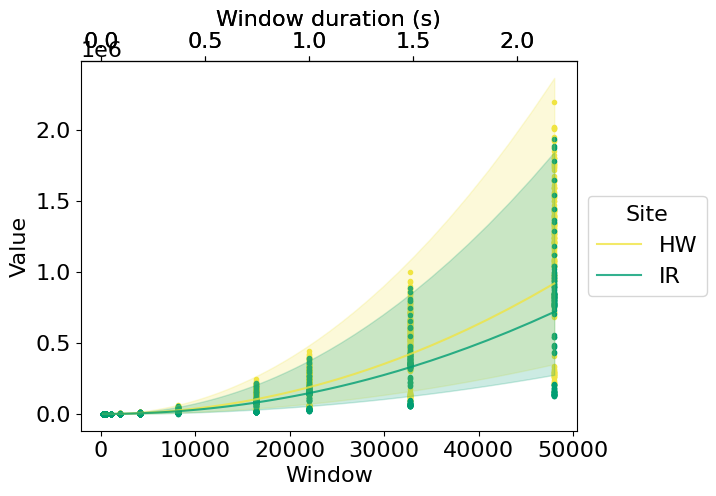

In [21]:
carara_broadband_BIO_fig


## Big Vicky

In [22]:
# settings and frequency bands
vicky_settings = BigVickySettings
vicky_settings.data_location = os.path.expanduser(vicky_settings.data_location)
test_bands = [("broadband", (100, vicky_settings.sample_rate), False),
              ("shrimp", vicky_settings.shrimp_frequencies, False),
              ("shrimp", vicky_settings.shrimp_frequencies, True),
              ("fish", vicky_settings.fish_frequencies, False),
              ("fish", vicky_settings.fish_frequencies, True)]


In [23]:
vicky_toolbox = BigVickyToolbox(vicky_settings, fft_window_sizes, test_bands, indices_of_interest)

In [24]:
vicky_index_values = vicky_toolbox.get_index_values(output_file="output/vicky_index_values.pkl")

In [25]:
vicky_df = vicky_toolbox.create_dataframe(vicky_index_values, output_path="output/vicky_dataframe.pkl")

### Big Vicky - broadband ACI


In [26]:
vicky_extracted_broadband_ACI_fig, vicky_extracted_broadband_ACI_ratio_summary = experiment(vicky_df,
          broadband_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using ACI
Compiling Stan program...

Start sampling

starting worker pid=2757740 on localhost:11159 at 15:49:26.675
starting worker pid=2757755 on localhost:11159 at 15:49:26.746
starting worker pid=2757770 on localhost:11159 at 15:49:26.817
starting worker pid=2757785 on localhost:11159 at 15:49:26.886
starting worker pid=2757800 on localhost:11159 at 15:49:26.955

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000474 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 4.74 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000474 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 4.74 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%] 

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [27]:
print(vicky_extracted_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00441



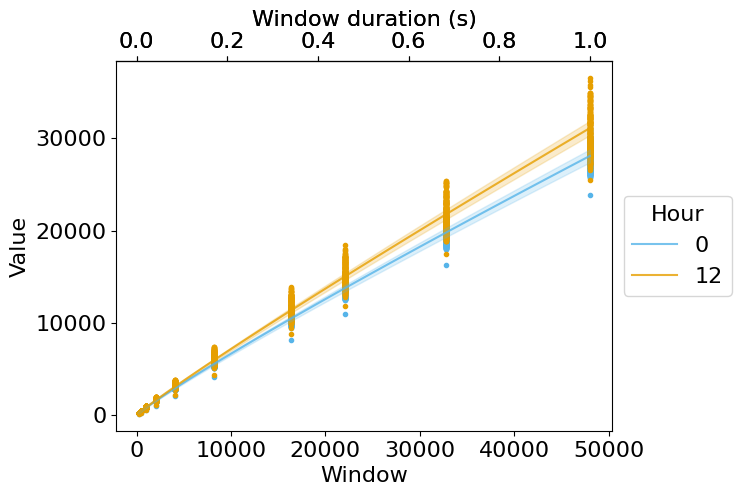

In [28]:
vicky_extracted_broadband_ACI_fig


### Big Vicky - extracted fish ACI


In [29]:
vicky_extracted_fish_ACI_fig, vicky_extracted_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using ACI
Compiling Stan program...

Start sampling

starting worker pid=2759196 on localhost:11159 at 15:56:49.398
starting worker pid=2759211 on localhost:11159 at 15:56:49.469
starting worker pid=2759226 on localhost:11159 at 15:56:49.540
starting worker pid=2759241 on localhost:11159 at 15:56:49.609
starting worker pid=2759256 on localhost:11159 at 15:56:49.678

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000836 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.36 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000852 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.52 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [30]:
print(vicky_extracted_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.09 0.00757



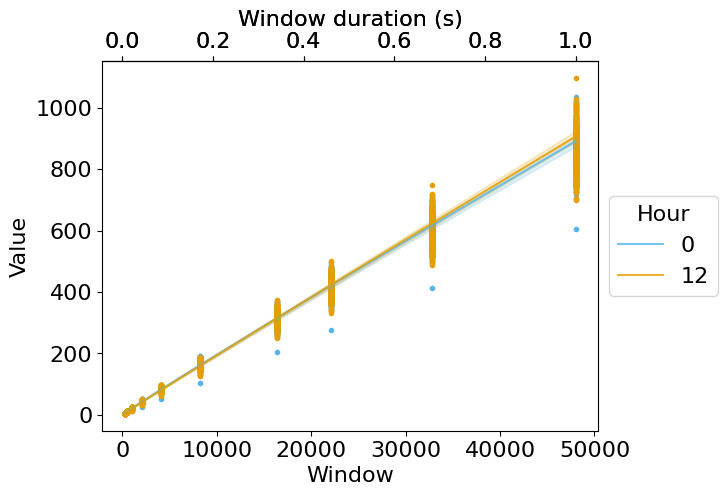

In [31]:
vicky_extracted_fish_ACI_fig


### Big Vicky - extracted shrimp ACI


In [32]:
vicky_extracted_shrimp_ACI_fig, vicky_extracted_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using ACI
Compiling Stan program...

Start sampling

starting worker pid=2760161 on localhost:11159 at 16:00:33.611
starting worker pid=2760176 on localhost:11159 at 16:00:33.681
starting worker pid=2760191 on localhost:11159 at 16:00:33.750
starting worker pid=2760206 on localhost:11159 at 16:00:33.819
starting worker pid=2760221 on localhost:11159 at 16:00:33.888

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000843 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.43 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000876 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.76 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (W

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [33]:
print(vicky_extracted_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.15 0.00555



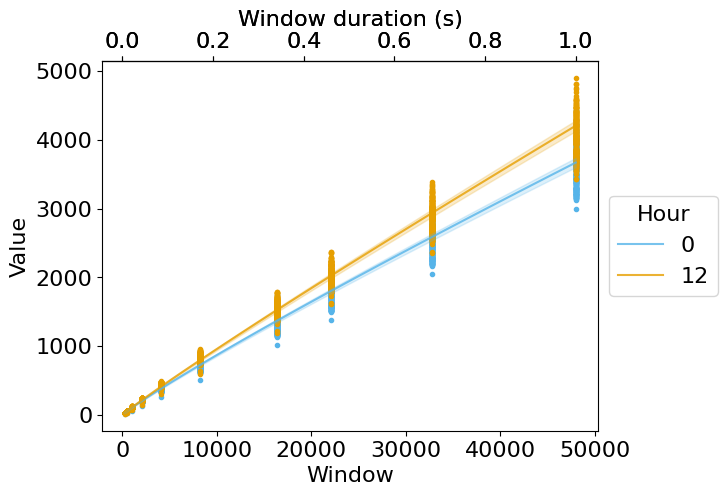

In [34]:
vicky_extracted_shrimp_ACI_fig


### Big Vicky - filtered fish ACI


In [35]:
vicky_filtered_fish_ACI_fig, vicky_filtered_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing ACI
Compiling Stan program...

Start sampling

starting worker pid=2762310 on localhost:11159 at 16:05:18.670
starting worker pid=2762325 on localhost:11159 at 16:05:18.739
starting worker pid=2762340 on localhost:11159 at 16:05:18.809
starting worker pid=2762355 on localhost:11159 at 16:05:18.877
starting worker pid=2762370 on localhost:11159 at 16:05:18.945

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000831 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.31 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000817 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.17 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [36]:
print(vicky_filtered_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00173



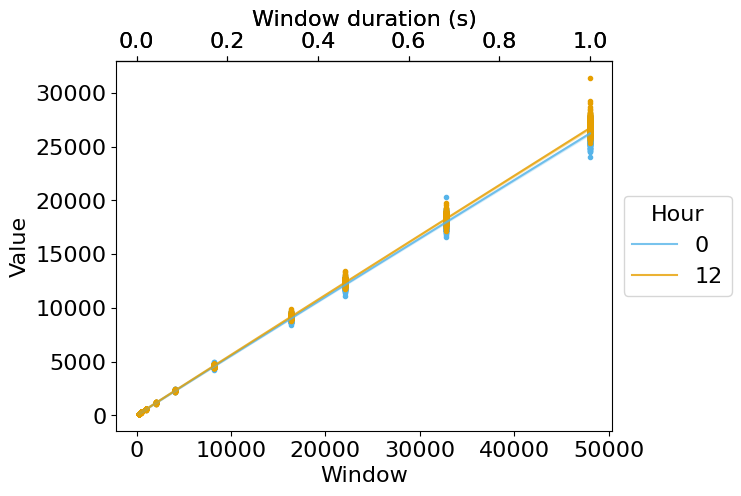

In [37]:
vicky_filtered_fish_ACI_fig


### Big Vicky - filtered shrimp ACI


In [38]:
vicky_filtered_shrimp_ACI_fig, vicky_filtered_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing ACI
Compiling Stan program...

Start sampling

starting worker pid=2764359 on localhost:11159 at 16:19:23.756
starting worker pid=2764374 on localhost:11159 at 16:19:23.825
starting worker pid=2764389 on localhost:11159 at 16:19:23.895
starting worker pid=2764404 on localhost:11159 at 16:19:23.964
starting worker pid=2764419 on localhost:11159 at 16:19:24.032

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000838 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.38 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00083 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.3 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [39]:
print(vicky_filtered_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.05 0.00224



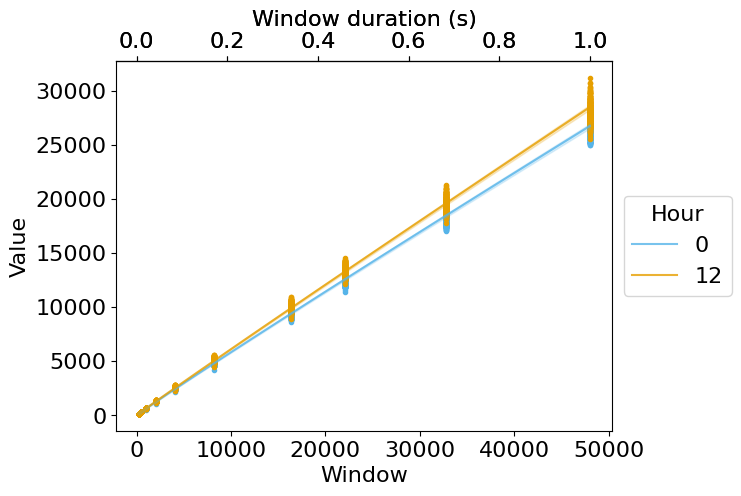

In [40]:
vicky_filtered_shrimp_ACI_fig


### Big Vicky - broadband ADI


In [41]:
vicky_extracted_broadband_ADI_fig, vicky_extracted_broadband_ADI_ratio_summary = experiment(vicky_df,
          broadband_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using ADI
Compiling Stan program...

Start sampling

starting worker pid=2765873 on localhost:11159 at 16:28:38.012
starting worker pid=2765888 on localhost:11159 at 16:28:38.082
starting worker pid=2765903 on localhost:11159 at 16:28:38.156
starting worker pid=2765918 on localhost:11159 at 16:28:38.224
starting worker pid=2765933 on localhost:11159 at 16:28:38.291

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000825 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000826 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.26 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%] 

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [42]:
print(vicky_extracted_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.07 0.00472



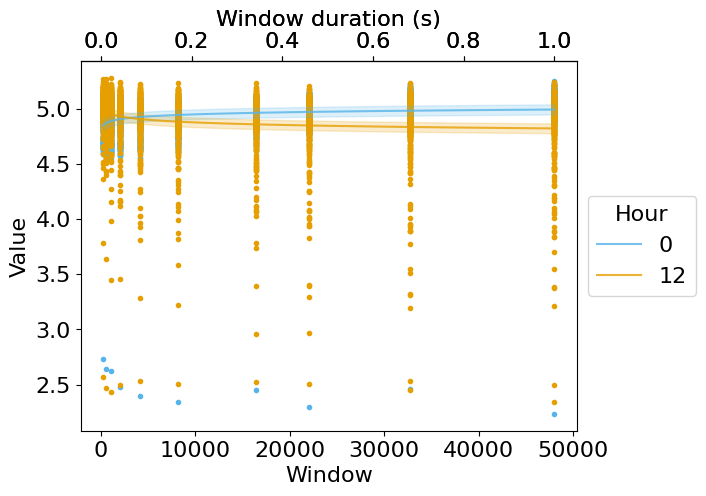

In [43]:
vicky_extracted_broadband_ADI_fig


### Big Vicky - extracted fish ADI


In [44]:
vicky_extracted_fish_ADI_fig, vicky_extracted_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using ADI
Compiling Stan program...

Start sampling

starting worker pid=2766939 on localhost:11159 at 16:32:57.487
starting worker pid=2766954 on localhost:11159 at 16:32:57.556
starting worker pid=2766969 on localhost:11159 at 16:32:57.626
starting worker pid=2766984 on localhost:11159 at 16:32:57.695
starting worker pid=2766999 on localhost:11159 at 16:32:57.764

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000821 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.21 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000793 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.93 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [45]:
print(vicky_extracted_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.04 0.00854



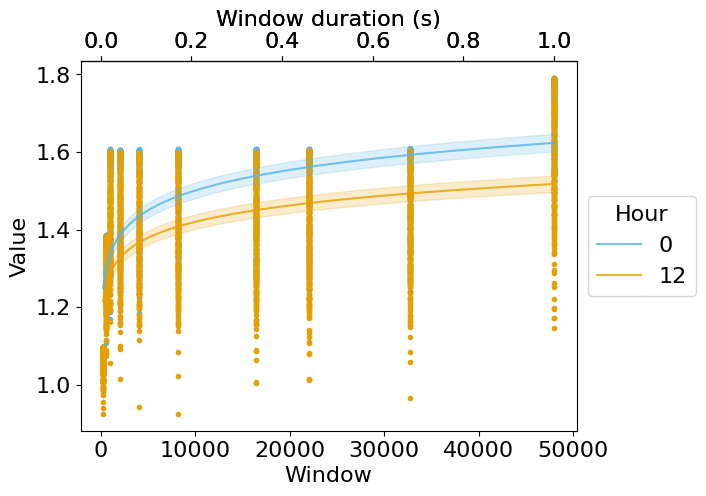

In [46]:
vicky_extracted_fish_ADI_fig


### Big Vicky - extracted shrimp ADI


In [47]:
vicky_extracted_shrimp_ADI_fig, vicky_extracted_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using ADI
Compiling Stan program...

Start sampling

starting worker pid=2767874 on localhost:11159 at 16:36:35.032
starting worker pid=2767889 on localhost:11159 at 16:36:35.101
starting worker pid=2767904 on localhost:11159 at 16:36:35.169
starting worker pid=2767919 on localhost:11159 at 16:36:35.239
starting worker pid=2767934 on localhost:11159 at 16:36:35.307

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00082 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.2 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000816 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.16 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [48]:
print(vicky_extracted_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00110



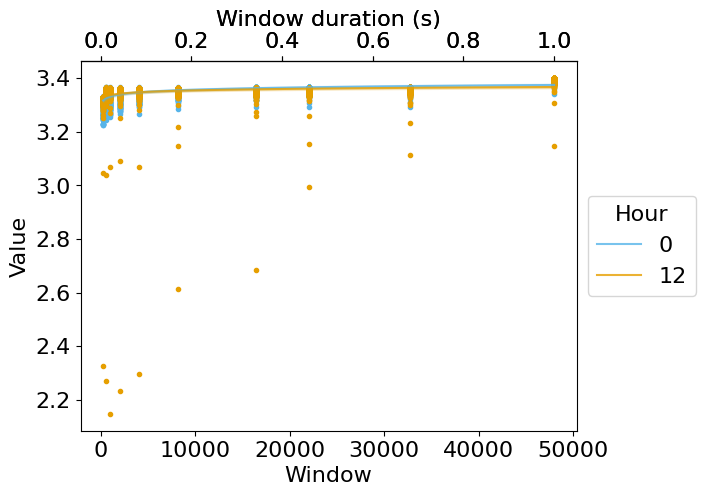

In [49]:
vicky_extracted_shrimp_ADI_fig


### Big Vicky - filtered fish ADI


In [50]:
vicky_filtered_fish_ADI_fig, vicky_filtered_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing ADI
Compiling Stan program...

Start sampling

starting worker pid=2769820 on localhost:11159 at 16:49:58.853
starting worker pid=2769835 on localhost:11159 at 16:49:58.921
starting worker pid=2769850 on localhost:11159 at 16:49:58.990
starting worker pid=2769865 on localhost:11159 at 16:49:59.057
starting worker pid=2769880 on localhost:11159 at 16:49:59.125

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00083 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.3 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000813 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.13 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [51]:
print(vicky_filtered_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00427



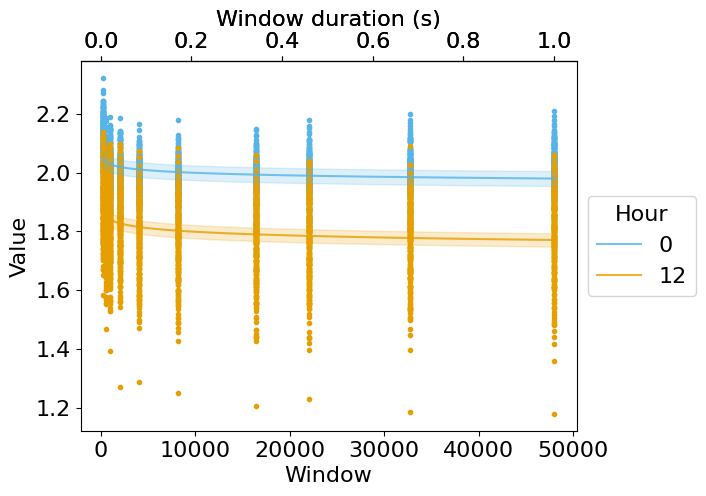

In [52]:
vicky_filtered_fish_ADI_fig


### Big Vicky - filtered shrimp ADI


In [53]:
vicky_filtered_shrimp_ADI_fig, vicky_filtered_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing ADI
Compiling Stan program...

Start sampling

starting worker pid=2770926 on localhost:11159 at 16:54:28.100
starting worker pid=2770941 on localhost:11159 at 16:54:28.167
starting worker pid=2770956 on localhost:11159 at 16:54:28.235
starting worker pid=2770971 on localhost:11159 at 16:54:28.302
starting worker pid=2770986 on localhost:11159 at 16:54:28.369

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.0008 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000807 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.07 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [54]:
print(vicky_filtered_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00123



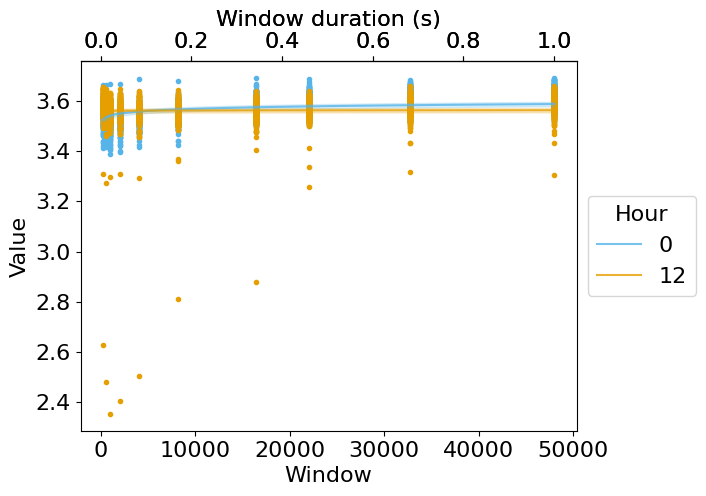

In [55]:
vicky_filtered_shrimp_ADI_fig


### Big Vicky - broadband AEI


In [56]:
vicky_extracted_broadband_AEI_fig, vicky_extracted_broadband_AEI_ratio_summary = experiment(vicky_df,
          broadband_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using AEI
Compiling Stan program...

Start sampling

starting worker pid=2772670 on localhost:11159 at 17:05:32.098
starting worker pid=2772685 on localhost:11159 at 17:05:32.181
starting worker pid=2772701 on localhost:11159 at 17:05:32.249
starting worker pid=2772720 on localhost:11159 at 17:05:32.318
starting worker pid=2772752 on localhost:11159 at 17:05:32.386

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001168 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.68 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001146 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 11.46 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [57]:
print(vicky_extracted_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.33 0.0146



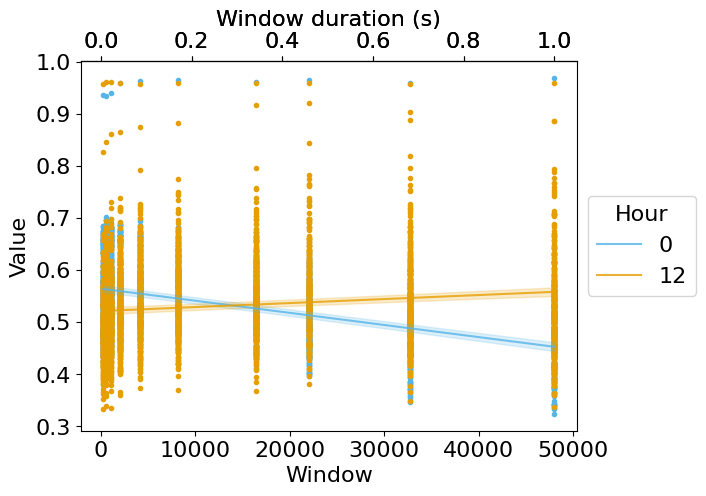

In [58]:
vicky_extracted_broadband_AEI_fig


### Big Vicky - extracted fish AEI


In [59]:
vicky_extracted_fish_AEI_fig, vicky_extracted_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using AEI
Compiling Stan program...

Start sampling

starting worker pid=2780288 on localhost:11159 at 18:47:57.706
starting worker pid=2780303 on localhost:11159 at 18:47:57.777
starting worker pid=2780318 on localhost:11159 at 18:47:57.848
starting worker pid=2780333 on localhost:11159 at 18:47:57.918
starting worker pid=2780348 on localhost:11159 at 18:47:57.986

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001163 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.63 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00116 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 11.6 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [60]:
print(vicky_extracted_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.10 0.0413



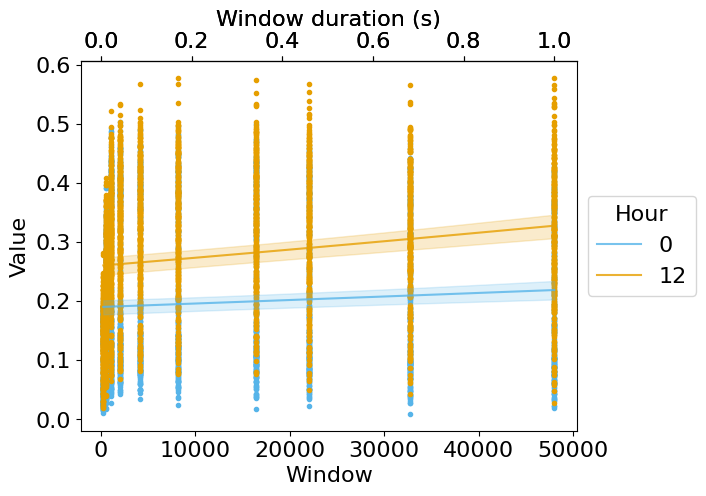

In [61]:
vicky_extracted_fish_AEI_fig


### Big Vicky - extracted shrimp AEI


In [62]:
vicky_extracted_shrimp_AEI_fig, vicky_extracted_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using AEI
Compiling Stan program...

Start sampling

starting worker pid=2787609 on localhost:11159 at 20:29:54.532
starting worker pid=2787624 on localhost:11159 at 20:29:54.606
starting worker pid=2787639 on localhost:11159 at 20:29:54.678
starting worker pid=2787654 on localhost:11159 at 20:29:54.748
starting worker pid=2787669 on localhost:11159 at 20:29:54.816

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001109 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.09 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001165 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 11.65 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [63]:
print(vicky_extracted_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.98 0.0665



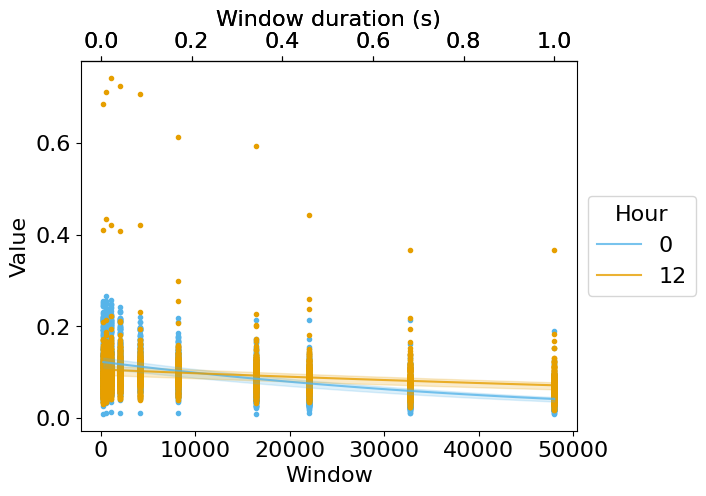

In [64]:
vicky_extracted_shrimp_AEI_fig


### Big Vicky - filtered fish AEI


In [65]:
vicky_filtered_fish_AEI_fig, vicky_filtered_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing AEI
Compiling Stan program...

Start sampling

starting worker pid=2795348 on localhost:11159 at 22:11:55.510
starting worker pid=2795363 on localhost:11159 at 22:11:55.579
starting worker pid=2795378 on localhost:11159 at 22:11:55.649
starting worker pid=2795393 on localhost:11159 at 22:11:55.719
starting worker pid=2795408 on localhost:11159 at 22:11:55.786

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001164 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.64 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00112 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 11.2 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [66]:
print(vicky_filtered_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean       sd
  <dbl>    <dbl>
1  1.00 0.000215



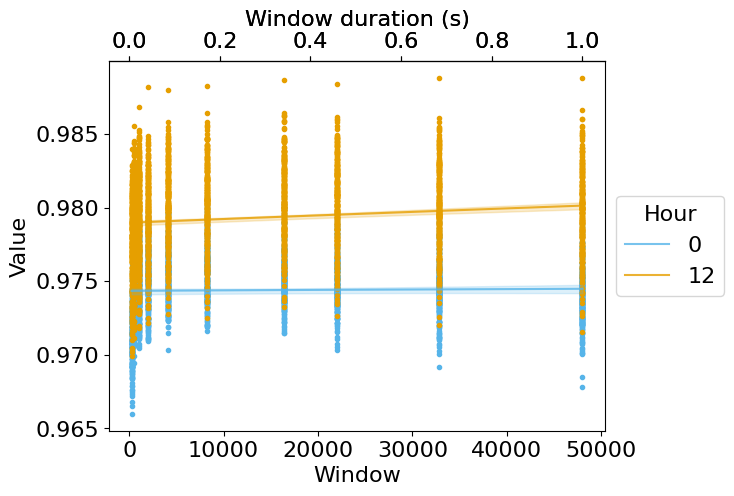

In [67]:
vicky_filtered_fish_AEI_fig


### Big Vicky - filtered shrimp AEI


In [68]:
vicky_filtered_shrimp_AEI_fig, vicky_filtered_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing AEI
Compiling Stan program...

Start sampling

starting worker pid=2803869 on localhost:11159 at 23:52:50.415
starting worker pid=2803884 on localhost:11159 at 23:52:50.485
starting worker pid=2803899 on localhost:11159 at 23:52:50.554
starting worker pid=2803914 on localhost:11159 at 23:52:50.624
starting worker pid=2803929 on localhost:11159 at 23:52:50.693

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001188 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.88 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001167 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 11.67 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [69]:
print(vicky_filtered_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00123



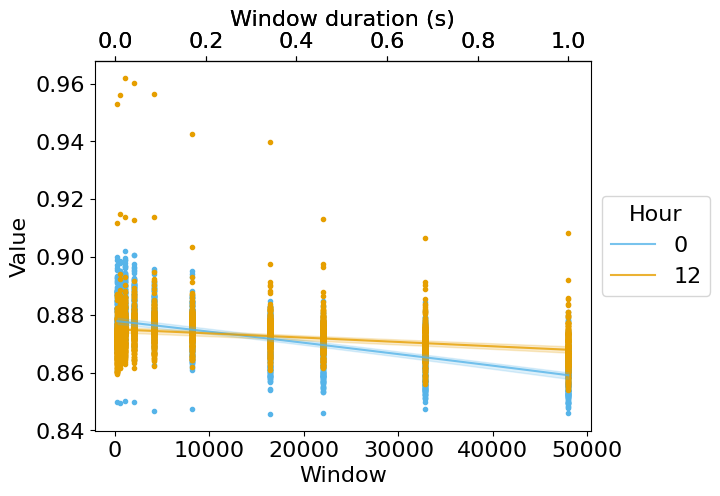

In [70]:
vicky_filtered_shrimp_AEI_fig


### Big Vicky - broadband BIO


In [71]:
vicky_extracted_broadband_BIO_fig, vicky_extracted_broadband_BIO_ratio_summary = experiment(vicky_df,
          broadband_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using BIO
Compiling Stan program...

Start sampling

starting worker pid=2811979 on localhost:11159 at 01:34:10.400
starting worker pid=2811995 on localhost:11159 at 01:34:10.468
starting worker pid=2812010 on localhost:11159 at 01:34:10.537
starting worker pid=2812025 on localhost:11159 at 01:34:10.605
starting worker pid=2812040 on localhost:11159 at 01:34:10.674

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00082 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.2 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000851 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.51 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [72]:
print(vicky_extracted_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00781



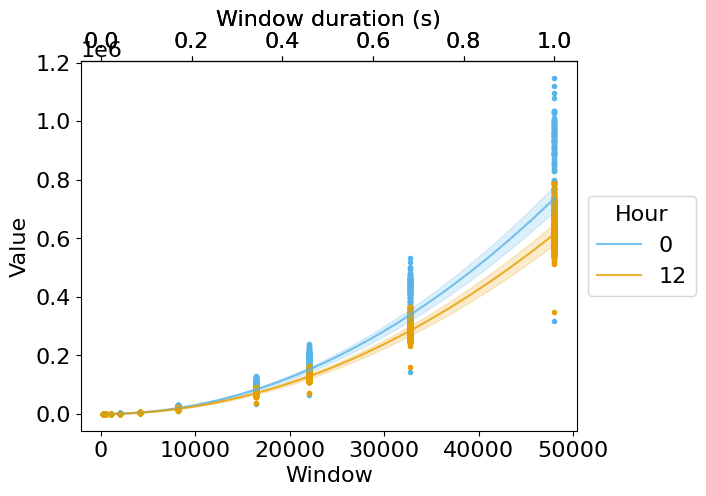

In [73]:
vicky_extracted_broadband_BIO_fig


### Big Vicky - extracted fish BIO


In [74]:
vicky_extracted_fish_BIO_fig, vicky_extracted_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using BIO
Compiling Stan program...

Start sampling

starting worker pid=2813264 on localhost:11159 at 01:40:05.905
starting worker pid=2813279 on localhost:11159 at 01:40:05.974
starting worker pid=2813294 on localhost:11159 at 01:40:06.043
starting worker pid=2813309 on localhost:11159 at 01:40:06.112
starting worker pid=2813324 on localhost:11159 at 01:40:06.180

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000822 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000808 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.08 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [75]:
print(vicky_extracted_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.27 0.0462



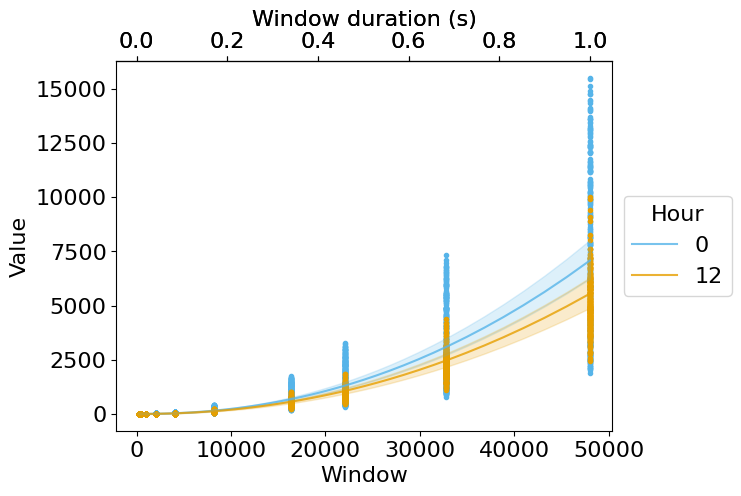

In [76]:
vicky_extracted_fish_BIO_fig


### Big Vicky - extracted shrimp BIO


In [77]:
vicky_extracted_shrimp_BIO_fig, vicky_extracted_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using BIO
Compiling Stan program...

Start sampling

starting worker pid=2814238 on localhost:11159 at 01:43:39.162
starting worker pid=2814253 on localhost:11159 at 01:43:39.231
starting worker pid=2814268 on localhost:11159 at 01:43:39.300
starting worker pid=2814283 on localhost:11159 at 01:43:39.369
starting worker pid=2814298 on localhost:11159 at 01:43:39.437

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000814 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.14 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000878 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.78 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%]  (W

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [78]:
print(vicky_extracted_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.03 0.0149



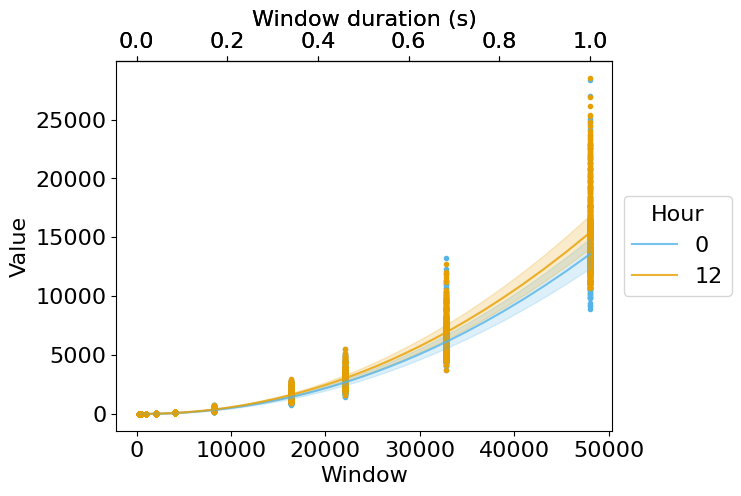

In [79]:
vicky_extracted_shrimp_BIO_fig


### Big Vicky - filtered fish BIO


In [80]:
vicky_filtered_fish_BIO_fig, vicky_filtered_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing BIO
Compiling Stan program...

Start sampling

starting worker pid=2815365 on localhost:11159 at 01:48:06.577
starting worker pid=2815380 on localhost:11159 at 01:48:06.646
starting worker pid=2815395 on localhost:11159 at 01:48:06.715
starting worker pid=2815410 on localhost:11159 at 01:48:06.783
starting worker pid=2815425 on localhost:11159 at 01:48:06.851

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000881 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.81 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000855 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.55 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [81]:
print(vicky_filtered_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.06 0.00230



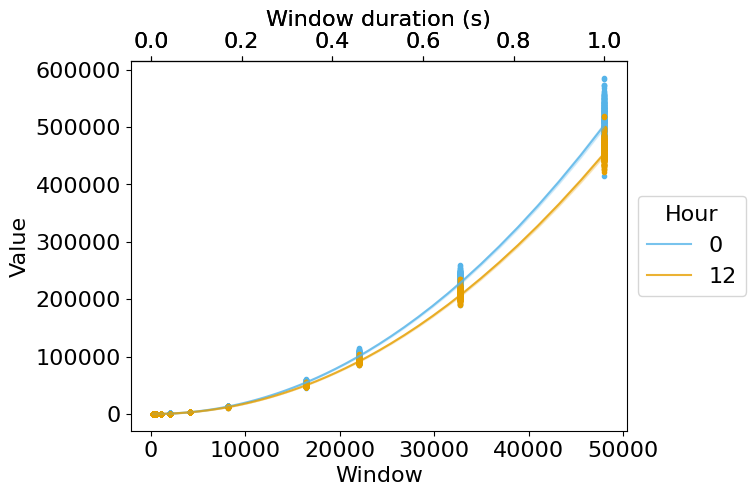

In [82]:
vicky_filtered_fish_BIO_fig


### Big Vicky - filtered shrimp BIO


In [83]:
vicky_filtered_shrimp_BIO_fig, vicky_filtered_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing BIO
Compiling Stan program...

Start sampling

starting worker pid=2816994 on localhost:11159 at 01:57:35.473
starting worker pid=2817009 on localhost:11159 at 01:57:35.543
starting worker pid=2817024 on localhost:11159 at 01:57:35.613
starting worker pid=2817039 on localhost:11159 at 01:57:35.682
starting worker pid=2817054 on localhost:11159 at 01:57:35.750

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00084 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.4 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00081 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.1 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 10000 [  0%

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [84]:
print(vicky_filtered_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00256



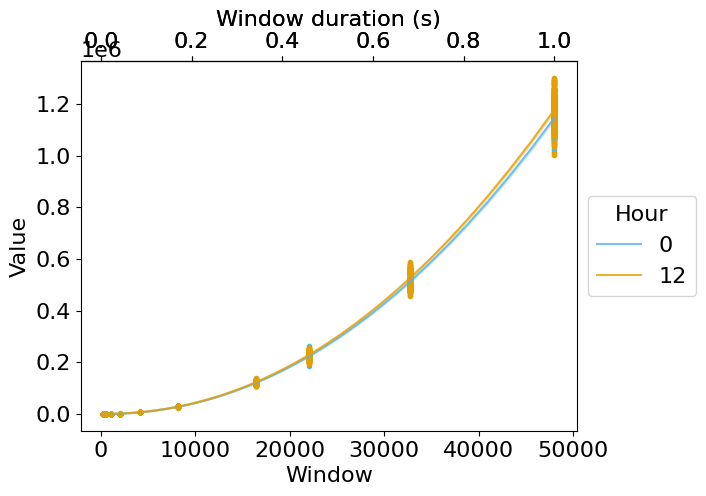

In [85]:
vicky_filtered_shrimp_BIO_fig
